In [73]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import History

# Transfer learning

<br>

<img src="Grafika/transfer_learning.png" width="550">

**Transfer learning** (transfer "wiedzy") - wykorzystanie nauczonych przez kogoś sieci do naszego problemu. Możliwe dzięki temu, że cechy wykrywane przez sieci w głębokich warstwach mogą być uniwersalne i przydatne w różnych problemach.


<img src="Grafika/Slide6.png" width="550">

### VGG16

In [75]:
from keras.applications import VGG16, InceptionV3
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### InceptionV3

In [76]:
inc = InceptionV3()
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 149, 149, 32) 864         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 149, 149, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 149, 149, 32) 0           batch_normalization_377[0][0]    
_______________________________________________________________________________________

# Zad
Trzeba nadać wymiar wejści anaszej sieci
```python
h,w = 32, 32
```

In [77]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

In [78]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [79]:
len(model.layers)

19

# Zad 
Zbudujmy siec z 
* VGG16 dla wejścia h,w = 32, 32
* Flatten
* Dense
* Dense

In [80]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(4, activation='sigmoid'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential_15 (Sequential)   (None, 4)                 132356    
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [81]:
# model.summary()
# top_model.summary()

In [82]:
from keras.datasets import cifar10
from keras.utils import np_utils
# from scipy.misc import toimage

import numpy as np

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

nb_classes = 4
n_samples = 7000

X_train, y_train = X_train[np.where(y_train<nb_classes)[0]][:n_samples], y_train[np.where(y_train<nb_classes)[0]][:n_samples]
X_test, y_test = X_test[np.where(y_test<nb_classes)[0]], y_test[np.where(y_test<nb_classes)[0]]

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train,return_counts=True))
print(X_train[0].shape)

# normalize inputs from 0-255 to 0.0-1.0

X_train = X_train/255
X_test = X_test/255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

X_train[0].shape

(7000, 32, 32, 3)
(4000, 32, 32, 3)
(array([0, 1, 2, 3], dtype=uint8), array([1738, 1733, 1779, 1750], dtype=int64))
(32, 32, 3)


(32, 32, 3)

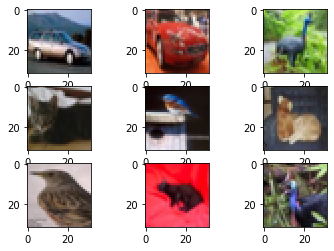

In [83]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [88]:
X_train.shape[0]/32

218.75

In [90]:
# model.evaluate(X_test,y_test)
history_tr = History()
early_stopping = EarlyStopping(patience=5,monitor="val_loss")
model_transfer.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model_transfer.fit(X_train, y_train, validation_split=0.25,epochs=100,batch_size=32,callbacks=[early_stopping, history_tr])
model_transfer.evaluate(X_test,y_test)

Train on 5250 samples, validate on 1750 samples
Epoch 1/100
5248/5250 [============================>.] - ETA: 0s - loss: 0.4706 - accuracy: 0.8203

KeyboardInterrupt: 

In [69]:
np.savetxt("cifar_10_part_conv_Tr_Le_tr.txt", history_tr.history['accuracy'])
np.savetxt("cifar_10_part_conv_Tr_Le_te.txt", history_tr.history['val_accuracy'])

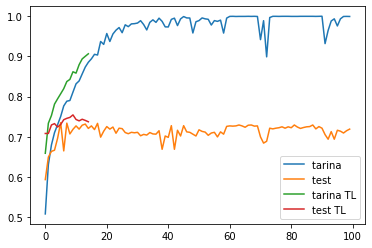

In [71]:
history_11 = np.loadtxt("cifar_10_part_conv_tr.txt")
history_12 = np.loadtxt("cifar_10_part_conv_te.txt")

plt.plot(history_11, label = "tarina ")
plt.plot(history_12, label = "test ")

plt.plot(history_tr.history['accuracy'], label = "tarina TL")
plt.plot(history_tr.history['val_accuracy'], label = "test TL")


plt.legend()
plt.show()